In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
df=pd.read_csv('/content/drive/MyDrive/diyabetik_retinopi_veri_seti /train.csv',sep=',')

In [ ]:
import os 
files=os.listdir('/content/drive/MyDrive/diyabetik_retinopi_veri_seti /train_images')
files.sort()

In [ ]:
#Ram yetmediği için resim boyutunu 400 400 den 300 300 e indiriyorum

import cv2 
img_list=[]
from tqdm import tqdm_notebook as tqdm
for i in tqdm(files):

  image=cv2.imread('/content/drive/MyDrive/diyabetik_retinopi_veri_seti /train_images//' + i)
  image=cv2.resize(image,(300,300))
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  kopya=image.copy()
  kopya=cv2.cvtColor(kopya,cv2.COLOR_RGB2GRAY)
  blur=cv2.GaussianBlur(kopya,(5,5),0)
  thresh=cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1]
  kontur=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  kontur=kontur[0][0]
  kontur=kontur[:,0,:]
  x1=tuple(kontur[kontur[:,0].argmin()])[0]
  x2=tuple(kontur[kontur[:,0].argmax()])[0]
  y1=tuple(kontur[kontur[:,1].argmin()])[1]
  y2=tuple(kontur[kontur[:,1].argmax()])[1]
  x=int(x2-x1)*4//50
  y=int(y2-y1)*5//50
  kopya2=image.copy()
  #Bazı resimler kendiliğinden kırpılmış olabilir onları kırpma işlemine dahil etmemek için aşağıdaki if bloğunu koyuyorum unutma!!!!
  if x2-x1>100 and y2-y1>100:
    kopya2=kopya2[ y1+y:y2-y , x1+x:x2-x]
    kopya2=cv2.resize(kopya2,(300,300))
  lab=cv2.cvtColor(kopya2,cv2.COLOR_RGB2LAB)
  l,a,b=cv2.split(lab)
  clahe=cv2.createCLAHE(clipLimit=5.0,tileGridSize=((8,8)))
  cl=clahe.apply(l)
  limg=cv2.merge((cl,a,b))
  son=cv2.cvtColor(limg,cv2.COLOR_LAB2RGB)
  med_son=cv2.medianBlur(son,3)
  arka_plan=cv2.medianBlur(son,37)
  maske=cv2.addWeighted(med_son,1,arka_plan,-1,255)
  son_img=cv2.bitwise_and(maske,med_son)
  img_list.append(son_img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/3662 [00:00<?, ?it/s]

In [ ]:
y_train=pd.get_dummies(df['diagnosis']).values
import numpy as np
y_train_son=np.ones(y_train.shape,dtype='uint8')
y_train_son[:,4]=y_train[:,4]
for i in range(3,-1,-1):
  y_train_son[:,i]=np.logical_or(y_train[:,i],y_train_son[:,i+1])
x_train=np.array(img_list)

x_train = x_train.astype(np.float32)
x_train=x_train/255
x_train=x_train.astype(np.uint8)



from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train,
                                             y_train_son,
                                             test_size=0.15,
                                             random_state=42,
                                             shuffle=True)

from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
data_generator=datagen.flow(x_train,y_train,batch_size=2,seed=2020)

In [ ]:
import keras 
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization,AveragePooling2D
from keras.optimizers import Adam 
from keras import layers


In [ ]:
model = Sequential()

#1. katman
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(300,300,3),activation='swish'))
model.add(BatchNormalization())

#2.katman

model.add(Conv2D(64, 3,activation='swish'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 

#3. katman
model.add(Conv2D(32, 3,activation='swish'))
model.add(BatchNormalization())


#4. katman
model.add(Conv2D(32, 3,activation='swish'))
model.add(BatchNormalization())

#5. katman
model.add(Conv2D(32, 3,activation='swish'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Tam bağlantı katmanı
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(128,activation='swish'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Çıkış katmanı

model.add(Dense(5))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.00005),metrics=['accuracy'])

from keras.callbacks import  ReduceLROnPlateau

lr=ReduceLROnPlateau(monitor='val_loss',
                     patience=3,
                     verbose=1,
                     mode='auto',
                     factor=0.25,
                     min_lr=0.000001)
                     
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 298, 298, 64)      1792      
                                                                 
 batch_normalization_23 (Bat  (None, 298, 298, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 296, 296, 64)      36928     
                                                                 
 batch_normalization_24 (Bat  (None, 296, 296, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 148, 148, 64)     0         
 2D)                                                             
                                                      

In [ ]:
history=model.fit_generator(data_generator,
                            steps_per_epoch=1000,
                            epochs=15,
                            validation_data=(x_val,y_val),
                            callbacks=[lr])

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


1000/1000 [==============================] - 37s 36ms/step - loss: 0.6861 - accuracy: 0.3955 - val_loss: 1.0805 - val_accuracy: 0.0055 - lr: 5.0000e-05
Epoch 2/15
1000/1000 [==============================] - 36s 36ms/step - loss: 0.6020 - accuracy: 0.6780 - val_loss: 0.9906 - val_accuracy: 0.0182 - lr: 5.0000e-05
Epoch 3/15
1000/1000 [==============================] - 35s 35ms/step - loss: 0.5326 - accuracy: 0.8620 - val_loss: 0.5566 - val_accuracy: 0.9436 - lr: 5.0000e-05
Epoch 4/15
1000/1000 [==============================] - 35s 35ms/step - loss: 0.4780 - accuracy: 0.9140 - val_loss: 0.5189 - val_accuracy: 0.6655 - lr: 5.0000e-05
Epoch 5/15
1000/1000 [==============================] - 35s 35ms/step - loss: 0.4483 - accuracy: 0.9690 - val_loss: 0.4427 - val_accuracy: 0.8655 - lr: 5.0000e-05
Epoch 6/15
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4178 - accuracy: 0.9930 - val_loss: 0.5671 - val_accuracy: 0.9527 - lr: 5.0000e-05
Epoch 7/15
1000/1000 [===========

??????????????????????????????????????????????????????????????????????????????????----------------------------------------------------------------------------------------

**Flatten--> softmax -->loss=categorical_crossentropy -->15 epoch -->best epoch =15 -->**
**loss: 3.8833 - accuracy: 0.9420 - val_loss: 4.7653 - val_accuracy: 0.9073 - lr: 1.0000e-06**

**GlobalAveragePooling2D -->loss=binary_crossentropy--> 15 epoch-->best epoch=14 -->** 
**loss: 0.3839 - accuracy: 1.0000 - val_loss: 0.7384 - val_accuracy: 0.9982 - lr: 5.0000e-05**

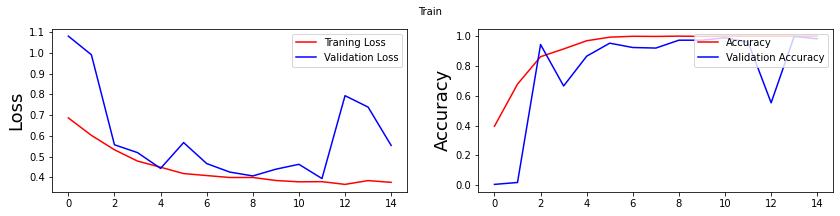

In [ ]:
from matplotlib import pyplot as plt 
plt.figure(figsize=(14,3))
plt.subplot(1,2,1)
plt.suptitle('Train',fontsize=10)
plt.ylabel('Loss',fontsize=18)
plt.plot(history.history['loss'],color='r',label='Traning Loss')
plt.plot(history.history['val_loss'],color='b',label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy',fontsize=18)
plt.plot(history.history['accuracy'],color='r',label='Accuracy')
plt.plot(history.history['val_accuracy'],color='b',label='Validation Accuracy')
plt.legend(loc='upper right')


plt.show()